In [1]:
%matplotlib inline
#%matplotlib notebook
import pylab
import numpy as np
import nengo
import scipy


In [2]:
class MultiplicativeNetwork(nengo.Network):
    def __init__(self, exponents, epsilon=0.001, n_neurons=200, 
                 input_dist=None,
                 output_dist=None,
                 n_samples=1000,
                 use_scaled_for_total_eval_points=True):
        super(MultiplicativeNetwork, self).__init__()
        self.exponents = np.array(exponents, dtype=float)
        self.w = self.exponents / np.sum(np.abs(self.exponents))
        self.epsilon = epsilon
        
        
        with self:
            # when connecting to this input, you must apply self.encode_func to transform the data
            self.input = nengo.Node(None, size_in=len(exponents), label='input')
            
            # this is the summed values (hidden layer 2 in the original formulation)
            self.total = nengo.Ensemble(n_neurons=n_neurons, dimensions=1)
            
            # this is the decoded value (output node in the original formulation)
            self.output = nengo.Node(None, size_in=1)
            
            # scale the inputs by w and sum them into the total population
            nengo.Connection(self.input, self.total, transform=[self.w], synapse=None)
            
            # apply the bias
            self.bias = nengo.Node([np.sum(self.w)-1], label='bias')
            nengo.Connection(self.bias, self.total, synapse=None)
            
            # decode back out to the original 0-1 range
            nengo.Connection(self.total, self.output, function=self.decode_func, 
                             synapse=None)
        
        
        if output_dist is not None:
            eval_points = output_dist.sample(n_samples, d=1)
        else:
            if input_dist is None:
                input_dist = [nengo.dists.Uniform(self.epsilon, 1) for i in range(len(exponents))]
            eval_points = np.ones((n_samples,1))
            for i, exp in enumerate(self.exponents):
                input_pts = input_dist[i].sample(n_samples, d=1)
                eval_points *= input_pts**exp
                
        if use_scaled_for_total_eval_points:
            self.total.eval_points = self.encode_func_scaled(eval_points)
        else:
            self.total.eval_points = self.encode_func(eval_points)
                        
    # the mapping from total back to the original 0-1 range
    def decode_func(self, x):
        return self.epsilon ** (self.ialpha(x)*np.sum(np.abs(self.exponents)))
    
    # the transformation for a single input
    def encode_func(self, x):
        x = np.maximum(x, self.epsilon)
        return self.alpha(np.log(x)/np.log(self.epsilon))
    
    # the inverse of the decode_func
    def encode_func_scaled(self, x):
        x = np.maximum(x, self.epsilon)
        return self.alpha(np.log(x)/np.log(self.epsilon)/np.sum(np.abs(self.exponents)))
        
    def alpha(self, x):
        a = self.epsilon
        b = 1
        return (x - (a+b)/2)*2/(b-a)
    def ialpha(self, x):
        a = self.epsilon
        b = 1
        return (x/2*(b-a))+(a+b)/2        


This version of the Bezier model attempts to learn in neuron activity space, rather than in weight space.  The EnsembleArrays in ```self.stored_weights``` hold the coefficients, a recurrent connection keeps them maintained over time, and the error is computed and fed into them.

At the moment, this is using the standard default Nengo product networks, since I wasn't sure if these needed to handle negative numbers or not.

In [58]:
from scipy.special import binom

class BezierTensorProductApproximation(nengo.Network):
    
    
    def __init__(self, n_inputs, n_outputs, degree=2, weights=None, epsilon=0.001, n_neurons=200, 
                 ):
        
        
        self.degree = degree
        super(BezierTensorProductApproximation, self).__init__() 
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_neurons = n_neurons
        self.weights = weights
        
        
        with self:
            #self.input = nengo.Node(None, size_in=n_inputs, label='input')
            self.input = nengo.networks.EnsembleArray(n_neurons=200, n_ensembles=n_inputs)

            self.basis = [ nengo.networks.EnsembleArray(n_neurons=self.n_neurons, 
                                                        n_ensembles=degree+1, 
                                                        label="basis_%d" % i) 
                          for i in range(n_inputs)  ]

            for i, b in enumerate(self.basis):
                for j in range(self.degree+1):
                    nengo.Connection(self.input.ea_ensembles[i], b.input[j], function=self.get_basis(j))

            self.mults = []


            self.output = nengo.networks.EnsembleArray(n_neurons=self.n_neurons,
                                                       n_ensembles=self.n_outputs,
                                                       label='output')



            self.indices = np.array([i for i in np.ndindex(*[self.degree+1]*self.n_inputs)])


            if self.weights is None:
                self.correct_output = nengo.Node(None, size_in=self.n_outputs)

            for index in self.indices:

                mult = MultiplicativeNetwork(exponents=[1]*len(index))#,
                                             #label="tensor_%s" % ','.join(str(i) for i in str(index)))
                self.mults.append(mult)

                for i,j in enumerate(index):

                    nengo.Connection(self.basis[i].ea_ensembles[j],mult.input[i],function=mult.encode_func,
                                     eval_points=np.linspace(epsilon,1,1000).reshape(-1,1))
    
            self.stored_weights = []
            for out in range(n_outputs):
                prod = nengo.networks.Product(n_neurons, dimensions=len(self.indices))
                
                for index in range(len(self.indices)):
                    mult = self.mults[index]

                    nengo.Connection(mult.total,
                                     prod.A[index],
                                     function=mult.decode_func)
                    nengo.Connection(prod.output[index],
                                     self.output.input[out])
                        
                if self.weights is not None:
                    fixed = nengo.Node(self.weights[out])
                    nengo.Connection(fixed, prod.B)
                else:
                    weight_array = nengo.networks.EnsembleArray(n_neurons=self.n_neurons,
                                                           n_ensembles=len(self.indices),
                                                           label='weights')
                    nengo.Connection(weight_array.output, weight_array.input, synapse=0.1)
                    self.stored_weights.append(weight_array)
                    
                    
                    nengo.Connection(weight_array.output, prod.B)
                    
                    
                    prod2 = nengo.networks.Product(n_neurons, dimensions=len(self.indices))
                    for index in range(len(self.indices)):
                        mult = self.mults[index]
                        nengo.Connection(mult.total,
                                         prod2.A[index],
                                         function=mult.decode_func)
                        nengo.Connection(self.correct_output[out], prod2.B[index])
                        nengo.Connection(self.output.output,
                                         prod2.B[index],
                                         transform=-1
                                         )
                    nengo.Connection(prod2.output, weight_array.input, transform=1, synapse=0.01)
            

                    
        
    
    def get_basis(self, index):
        """
        Returns the basis function of the approximator given an index :math:`i`. 
        """
        
        def nested(t):
            #print(index,  binom(self.degree,index) * t**index * (1-t)**(self.degree-index) )
            return binom(self.degree,index) * t**index * (1-t)**(self.degree-index)
        
        return nested

    def get_all_bases(self, T):
        """
        ONLY FOR DEDUGGING
        """
         
        result = np.ones(self.indices.shape[0])
        for  index, r in zip(self.indices, range(len(result))):
            for i,t in zip(index,T):
                result[r] *= self.get_basis(i)(t)
        return result
    
    def get_target(self, x):
        """
        EVEN MORE ONLY FOR DEBUGGING
        """
        assert self.n_inputs == 1 , "WARNING: This works only for a single INPUT"
        weights = np.array([[0.75,1.0,0.0]])    
        return np.dot( weights, self.get_all_bases(x))

        
        

In [59]:
model = nengo.Network()
n_samples = 34
samples = np.linspace(0.0,1.0,n_samples)
D=1
with model:
    stim = nengo.Node(lambda t: samples[int(t / 0.3) % n_samples])
    p_stim = nengo.Probe(stim, synapse=None)
    weights=np.array([[0.75,1.0,0.0]])    
    weights=None
    bezier=BezierTensorProductApproximation(1,1, weights=weights)
    

    nengo.Connection(stim, bezier.correct_output, function=bezier.get_target)

    nengo.Connection(stim, bezier.input.input, synapse=0.01)    
    
    basis = nengo.Probe(bezier.basis[0].output, synapse=0.03)
    tp = [nengo.Probe(bezier.mults[i].output, synapse=0.03) for i in range(3)]
    out = nengo.Probe(bezier.output.output, synapse=0.03)
    wp = [nengo.Probe(w.output, synapse=0.03) for w in bezier.stored_weights]

   
    

In [60]:
sim = nengo.Simulator(model)
sim.run(10) 

Simulation finished in 0:00:39.                                                 


This seems to work behaviourally....

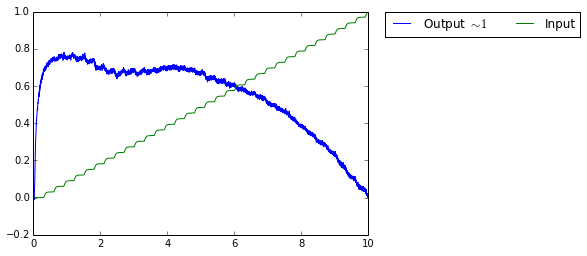

In [61]:
correct = np.ones_like(sim.trange())
for i in range(1):
    correct *= sim.data[p_stim][:,i]
correct = nengo.synapses.filt(correct,nengo.synapses.Lowpass(0.01),  dt=sim.dt)    
correct = nengo.synapses.filt(correct,nengo.synapses.Lowpass(0.01),  dt=sim.dt)    
correct = nengo.synapses.filt(correct,nengo.synapses.Lowpass(0.03),  dt=sim.dt)    
    

pylab.plot(sim.trange(),sim.data[out], label="Output $\sim 1$")
pylab.plot(sim.trange(), correct, label="Input")    
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=2)


But it doesn't find a stable set of coefficients.  I'm not sure what's going wrong here...

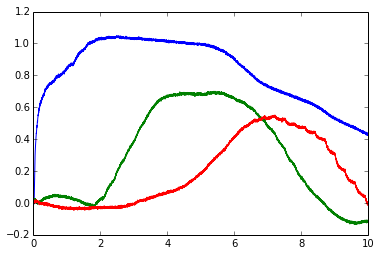

In [62]:
for p in wp:
    pylab.plot(sim.trange(), sim.data[p])